<a href="https://colab.research.google.com/github/ekvirika/WalmartRecruiting/blob/main/notebooks/model_experiment_patchtst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
!pip install wandb torch torchvision pandas numpy matplotlib seaborn scikit-learn mlflow

# Set up Kaggle API
!pip install kaggle

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24

In [3]:
# Upload your kaggle.json to Colab and run:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the dataset
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting
!unzip -q walmart-recruiting-store-sales-forecasting.zip

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 632MB/s]


In [5]:
!unzip -q train.csv.zip
!unzip -q stores.csv.zip
!unzip -q test.csv.zip
!unzip -q features.csv.zip

unzip:  cannot find or open stores.csv.zip, stores.csv.zip.zip or stores.csv.zip.ZIP.


# 1. Setup and Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Deep Learning and Time Series
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# MLflow for experiment tracking
import mlflow
import mlflow.pytorch
from mlflow.tracking import MlflowClient

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Environment setup complete!")


Environment setup complete!


# 2.DATA LOADING AND EXPLORATION

In [7]:
def load_walmart_data():
    """
    Load and explore Walmart sales data from Kaggle competition
    """
    print("Loading Walmart Sales Data...")

    # Load the datasets
    # Note: Replace with actual file paths
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    features_df = pd.read_csv('features.csv')
    stores_df = pd.read_csv('stores.csv')

    print(f"Train shape: {train_df.shape}")
    print(f"Test shape: {test_df.shape}")
    print(f"Features shape: {features_df.shape}")
    print(f"Stores shape: {stores_df.shape}")

    return train_df, test_df, features_df, stores_df

def explore_data(train_df, features_df, stores_df):
    """
    Explore the structure and patterns in the data
    """
    print("=== DATA EXPLORATION ===")

    # Check data types and missing values
    print("\nTrain Data Info:")
    print(train_df.info())
    print("\nMissing values in train:")
    print(train_df.isnull().sum())

    # Date range analysis
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    features_df['Date'] = pd.to_datetime(features_df['Date'])
    print(f"\nDate range: {train_df['Date'].min()} to {train_df['Date'].max()}")

    # Sales statistics
    print(f"\nSales statistics:")
    print(train_df['Weekly_Sales'].describe())

    # Store and department analysis
    print(f"\nNumber of unique stores: {train_df['Store'].nunique()}")
    print(f"Number of unique departments: {train_df['Dept'].nunique()}")

    # Visualization
    plt.figure(figsize=(15, 10))

    # Sales over time
    plt.subplot(2, 2, 1)
    monthly_sales = train_df.groupby(train_df['Date'].dt.to_period('M'))['Weekly_Sales'].sum()
    monthly_sales.plot(kind='line')
    plt.title('Monthly Sales Trend')
    plt.xticks(rotation=45)

    # Sales distribution
    plt.subplot(2, 2, 2)
    plt.hist(train_df['Weekly_Sales'], bins=50, edgecolor='black')
    plt.title('Sales Distribution')
    plt.xlabel('Weekly Sales')

    # Top stores by sales
    plt.subplot(2, 2, 3)
    top_stores = train_df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
    top_stores.plot(kind='bar')
    plt.title('Top 10 Stores by Total Sales')
    plt.xlabel('Store')

    # Sales by department
    plt.subplot(2, 2, 4)
    dept_sales = train_df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(10)
    dept_sales.plot(kind='bar')
    plt.title('Top 10 Departments by Sales')
    plt.xlabel('Department')

    plt.tight_layout()
    plt.show()


# 3. DATA PREPROCESSING

In [8]:
class WalmartDataProcessor:
    """
    Comprehensive data preprocessing for Walmart sales data
    """

    def __init__(self):
        self.scalers = {}
        self.feature_names = []

    def merge_datasets(self, train_df, features_df, stores_df):
        """
        Merge all datasets into a single dataframe
        """
        print("Merging datasets...")

        # Merge train with features
        merged_df = pd.merge(train_df, features_df, on=['Store', 'Date'], how='left')

        # Merge with stores
        merged_df = pd.merge(merged_df, stores_df, on='Store', how='left')

        print(f"Merged dataset shape: {merged_df.shape}")
        return merged_df

    def create_time_features(self, df):
        """
        Create time-based features from date column
        """
        print("Creating time features...")

        df = df.copy()
        df['Date'] = pd.to_datetime(df['Date'])

        # Extract time components
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Week'] = df['Date'].dt.isocalendar().week
        df['Day'] = df['Date'].dt.day
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df['DayOfYear'] = df['Date'].dt.dayofyear
        df['Quarter'] = df['Date'].dt.quarter

        # Cyclical encoding for seasonal patterns
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
        df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
        df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
        df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

        return df

    def handle_missing_values(self, df):
        """
        Handle missing values in the dataset
        """
        print("Handling missing values...")

        df = df.copy()

        # Fill missing values with appropriate strategies
        # For numerical features, use forward fill then backward fill
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

        # For categorical features, use mode
        categorical_cols = df.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df[col].isnull().sum() > 0:
                df[col] = df[col].fillna(df[col].mode()[0])

        print(f"Missing values after handling: {df.isnull().sum().sum()}")
        return df

    def create_lag_features(self, df, target_col='Weekly_Sales', lags=[1, 2, 4, 8, 12]):
        """
        Create lag features for time series
        """
        print("Creating lag features...")

        df = df.copy()
        df = df.sort_values(['Store', 'Dept', 'Date'])

        for lag in lags:
            df[f'{target_col}_lag_{lag}'] = df.groupby(['Store', 'Dept'])[target_col].shift(lag)

        return df

    def create_rolling_features(self, df, target_col='Weekly_Sales', windows=[4, 8, 12]):
        """
        Create rolling window features
        """
        print("Creating rolling features...")

        df = df.copy()
        df = df.sort_values(['Store', 'Dept', 'Date'])

        for window in windows:
            df[f'{target_col}_rolling_mean_{window}'] = (
                df.groupby(['Store', 'Dept'])[target_col]
                  .transform(lambda x: x.rolling(window=window, min_periods=1).mean())
            )
            df[f'{target_col}_rolling_std_{window}'] = (
                df.groupby(['Store', 'Dept'])[target_col]
                  .transform(lambda x: x.rolling(window=window, min_periods=1).std())
            )

        return df


    def prepare_features(self, df):
        """
        Prepare final feature set for modeling
        """
        print("Preparing features...")

        # Select features for modeling
        feature_cols = [
            'Store', 'Dept', 'Size', 'Type',
            'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
            'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'DayOfYear', 'Quarter',
            'Month_sin', 'Month_cos', 'Week_sin', 'Week_cos', 'DayOfWeek_sin', 'DayOfWeek_cos',
            'IsHoliday'
        ]

        # Add lag and rolling features
        lag_cols = [col for col in df.columns if 'lag_' in col]
        rolling_cols = [col for col in df.columns if 'rolling_' in col]

        feature_cols.extend(lag_cols)
        feature_cols.extend(rolling_cols)

        # Remove columns that don't exist
        feature_cols = [col for col in feature_cols if col in df.columns]

        # Handle categorical variables
        categorical_cols = ['Type']
        for col in categorical_cols:
            if col in df.columns:
                df[col] = pd.Categorical(df[col]).codes

        # Convert boolean to int
        if 'IsHoliday' in df.columns:
            df['IsHoliday'] = df['IsHoliday'].astype(int)

        self.feature_names = feature_cols
        return df, feature_cols


# 4. PATCHTST MODEL IMPLEMENTATION

In [9]:
class PatchTST(nn.Module):
    """
    PatchTST: A Time Series Transformer using Patching

    This model divides time series into patches and applies transformer
    architecture for forecasting. Key components:

    1. Patching: Divides input sequence into patches
    2. Patch Embedding: Converts patches to embeddings
    3. Positional Encoding: Adds position information
    4. Transformer Encoder: Processes patch embeddings
    5. Forecasting Head: Generates predictions
    """

    def __init__(self,
                 seq_len=52,          # Input sequence length (52 weeks)
                 pred_len=12,         # Prediction length
                 patch_len=4,         # Length of each patch
                 stride=2,            # Stride for patching
                 d_model=128,         # Model dimension
                 n_heads=8,           # Number of attention heads
                 n_layers=3,          # Number of transformer layers
                 d_ff=256,            # Feed forward dimension
                 dropout=0.1,         # Dropout rate
                 n_features=1):       # Number of input features

        super(PatchTST, self).__init__()

        self.seq_len = seq_len
        self.pred_len = pred_len
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model
        self.n_features = n_features

        # Calculate number of patches
        self.patch_num = (seq_len - patch_len) // stride + 1

        # Patch embedding layer
        self.patch_embedding = nn.Linear(patch_len * n_features, d_model)

        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.randn(self.patch_num, d_model))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Forecasting head
        self.forecasting_head = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, pred_len)
        )

        # Layer normalization
        self.layer_norm = nn.LayerNorm(d_model)

    def create_patches(self, x):
        """
        Create patches from input time series

        Args:
            x: Input tensor of shape (batch_size, seq_len, n_features)

        Returns:
            patches: Tensor of shape (batch_size, patch_num, patch_len * n_features)
        """
        batch_size, seq_len, n_features = x.shape

        # Create patches using unfold
        patches = x.unfold(dimension=1, size=self.patch_len, step=self.stride)
        # Reshape to (batch_size, patch_num, patch_len * n_features)
        patches = patches.reshape(batch_size, self.patch_num, -1)

        return patches

    def forward(self, x):
        """
        Forward pass of PatchTST

        Args:
            x: Input tensor of shape (batch_size, seq_len, n_features)

        Returns:
            predictions: Tensor of shape (batch_size, pred_len)
        """
        # Create patches
        patches = self.create_patches(x)  # (batch_size, patch_num, patch_len * n_features)

        # Patch embedding
        patch_embeddings = self.patch_embedding(patches)  # (batch_size, patch_num, d_model)

        # Add positional encoding
        patch_embeddings = patch_embeddings + self.positional_encoding

        # Apply layer normalization
        patch_embeddings = self.layer_norm(patch_embeddings)

        # Transformer encoder
        transformer_output = self.transformer(patch_embeddings)  # (batch_size, patch_num, d_model)

        # Global average pooling over patches
        pooled_output = transformer_output.mean(dim=1)  # (batch_size, d_model)

        # Forecasting head
        predictions = self.forecasting_head(pooled_output)  # (batch_size, pred_len)

        return predictions


# 5. DATASET CLASS


In [10]:
class WalmartTimeSeriesDataset(Dataset):
    """
    Custom dataset for Walmart time series data
    """

    def __init__(self, data, features, target, seq_len=52, pred_len=12, scaler=None):
        self.data = data
        self.features = features
        self.target = target
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.scaler = scaler

        # Group by store and department
        self.groups = data.groupby(['Store', 'Dept'])
        self.valid_indices = []

        # Find valid sequences
        for name, group in self.groups:
            group = group.sort_values('Date').reset_index(drop=True)
            if len(group) >= seq_len + pred_len:
                for i in range(len(group) - seq_len - pred_len + 1):
                    self.valid_indices.append((name, i, len(group)))

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        group_name, start_idx, group_len = self.valid_indices[idx]
        group = self.groups.get_group(group_name).sort_values('Date').reset_index(drop=True)

        # Extract sequence
        end_idx = start_idx + self.seq_len
        pred_end_idx = end_idx + self.pred_len

        # Features (using only target for univariate case)
        X = group[self.target].iloc[start_idx:end_idx].values
        y = group[self.target].iloc[end_idx:pred_end_idx].values

        # Reshape for model input
        X = X.reshape(-1, 1)  # (seq_len, 1)

        return torch.FloatTensor(X), torch.FloatTensor(y)



# 6. TRAINING FUNCTIONS


In [11]:
def train_patchtst(model, train_loader, val_loader, config):
    """
    Train PatchTST model with proper experiment tracking
    """
    # Setup MLflow experiment
    mlflow.set_experiment("PatchTST_Training")

    with mlflow.start_run(run_name="PatchTST_Training"):
        # Log hyperparameters
        mlflow.log_params(config)

        # Setup training components
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

        # Training loop
        train_losses = []
        val_losses = []
        best_val_loss = float('inf')

        for epoch in range(config['epochs']):
            # Training phase
            model.train()
            train_loss = 0.0

            for batch_idx, (data, target) in enumerate(train_loader):
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # Validation phase
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for data, target in val_loader:
                    output = model(data)
                    val_loss += criterion(output, target).item()

            # Calculate average losses
            train_loss = train_loss / len(train_loader)
            val_loss = val_loss / len(val_loader)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            # Update learning rate
            scheduler.step(val_loss)

            # Log metrics
            mlflow.log_metrics({
                'train_loss': train_loss,
                'val_loss': val_loss,
                'learning_rate': optimizer.param_groups[0]['lr']
            }, step=epoch)

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_patchtst_model.pth')

            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Log final metrics
        mlflow.log_metric('best_val_loss', best_val_loss)

        # Save model as artifact
        mlflow.pytorch.log_model(model, "patchtst_model")

        return model, train_losses, val_losses

def evaluate_model(model, test_loader, scaler=None):
    """
    Evaluate model performance
    """
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            predictions.append(output.numpy())
            actuals.append(target.numpy())

    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    # Calculate metrics
    mae = mean_absolute_error(actuals.flatten(), predictions.flatten())
    mse = mean_squared_error(actuals.flatten(), predictions.flatten())
    rmse = np.sqrt(mse)

    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'predictions': predictions,
        'actuals': actuals
    }


# 7. MAIN EXECUTION PIPELINE

In [12]:
def main():
    """
    Main execution pipeline for PatchTST on Walmart data
    """
    print("=== PATCHTST PIPELINE FOR WALMART SALES FORECASTING ===")

    # Configuration
    config = {
        'seq_len': 52,          # 52 weeks of history
        'pred_len': 12,         # Predict 12 weeks ahead
        'patch_len': 4,         # 4-week patches
        'stride': 2,            # Stride of 2
        'd_model': 128,         # Model dimension
        'n_heads': 8,           # Attention heads
        'n_layers': 3,          # Transformer layers
        'd_ff': 256,            # Feed forward dimension
        'dropout': 0.1,         # Dropout rate
        'batch_size': 32,       # Batch size
        'learning_rate': 0.001, # Learning rate
        'epochs': 100,          # Training epochs
        'train_ratio': 0.7,     # Training data ratio
        'val_ratio': 0.2        # Validation data ratio
    }

    # Step 1: Load and explore data
    print("\n1. Loading and exploring data...")
    try:
        train_df, test_df, features_df, stores_df = load_walmart_data()
        explore_data(train_df, features_df, stores_df)
    except FileNotFoundError:
        print("Data files not found. Please ensure you have the Walmart dataset files.")
        return

    # Step 2: Preprocess data
    print("\n2. Preprocessing data...")
    processor = WalmartDataProcessor()

    # Merge datasets
    merged_df = processor.merge_datasets(train_df, features_df, stores_df)

    # Create time features
    merged_df = processor.create_time_features(merged_df)

    # Handle missing values
    merged_df = processor.handle_missing_values(merged_df)

    # Create lag and rolling features
    merged_df = processor.create_lag_features(merged_df)
    merged_df = processor.create_rolling_features(merged_df)

    # Prepare features
    merged_df, feature_cols = processor.prepare_features(merged_df)

    # Remove rows with NaN values (created by lag features)
    merged_df = merged_df.dropna()

    print(f"Final dataset shape: {merged_df.shape}")
    print(f"Number of features: {len(feature_cols)}")

    # Step 3: Create datasets
    print("\n3. Creating datasets...")

    # Split data
    total_samples = len(merged_df)
    train_size = int(total_samples * config['train_ratio'])
    val_size = int(total_samples * config['val_ratio'])

    train_data = merged_df.iloc[:train_size]
    val_data = merged_df.iloc[train_size:train_size + val_size]
    test_data = merged_df.iloc[train_size + val_size:]

    # Create datasets
    train_dataset = WalmartTimeSeriesDataset(
        train_data, feature_cols, 'Weekly_Sales',
        config['seq_len'], config['pred_len']
    )

    val_dataset = WalmartTimeSeriesDataset(
        val_data, feature_cols, 'Weekly_Sales',
        config['seq_len'], config['pred_len']
    )

    test_dataset = WalmartTimeSeriesDataset(
        test_data, feature_cols, 'Weekly_Sales',
        config['seq_len'], config['pred_len']
    )

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Step 4: Initialize model
    print("\n4. Initializing PatchTST model...")
    model = PatchTST(
        seq_len=config['seq_len'],
        pred_len=config['pred_len'],
        patch_len=config['patch_len'],
        stride=config['stride'],
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        d_ff=config['d_ff'],
        dropout=config['dropout'],
        n_features=1  # Univariate time series
    )

    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

    # Step 5: Train model
    print("\n5. Training model...")
    trained_model, train_losses, val_losses = train_patchtst(
        model, train_loader, val_loader, config
    )

    # Step 6: Evaluate model
    print("\n6. Evaluating model...")
    results = evaluate_model(trained_model, test_loader)

    print(f"Test MAE: {results['MAE']:.4f}")
    print(f"Test MSE: {results['MSE']:.4f}")
    print(f"Test RMSE: {results['RMSE']:.4f}")

    # Step 7: Visualization
    print("\n7. Creating visualizations...")

    plt.figure(figsize=(15, 10))

    # Training curves
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Predictions vs Actuals
    plt.subplot(2, 2, 2)
    sample_predictions = results['predictions'][:100].flatten()
    sample_actuals = results['actuals'][:100].flatten()
    plt.scatter(sample_actuals, sample_predictions, alpha=0.5)
    plt.plot([sample_actuals.min(), sample_actuals.max()],
             [sample_actuals.min(), sample_actuals.max()], 'r--')
    plt.title('Predictions vs Actuals')
    plt.xlabel('Actual Sales')
    plt.ylabel('Predicted Sales')

    # Time series example
    plt.subplot(2, 2, 3)
    example_idx = 0
    example_pred = results['predictions'][example_idx]
    example_actual = results['actuals'][example_idx]

    plt.plot(range(len(example_actual)), example_actual, label='Actual', marker='o')
    plt.plot(range(len(example_pred)), example_pred, label='Predicted', marker='s')
    plt.title('Example Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Sales')
    plt.legend()

    # Residuals
    plt.subplot(2, 2, 4)
    residuals = sample_predictions - sample_actuals
    plt.hist(residuals, bins=30, edgecolor='black')
    plt.title('Residuals Distribution')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

    print("\n=== PIPELINE COMPLETED SUCCESSFULLY ===")

    return trained_model, results, config


# 8. INFERENCE PIPELINE


=== PATCHTST PIPELINE FOR WALMART SALES FORECASTING ===

1. Loading and exploring data...
Loading Walmart Sales Data...
Train shape: (421570, 5)
Test shape: (115064, 4)
Features shape: (8190, 12)
Stores shape: (45, 3)
=== DATA EXPLORATION ===

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB
None

Missing values in train:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

Date range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00

Sales statistics:
count    421570.000000
mean      15981.2

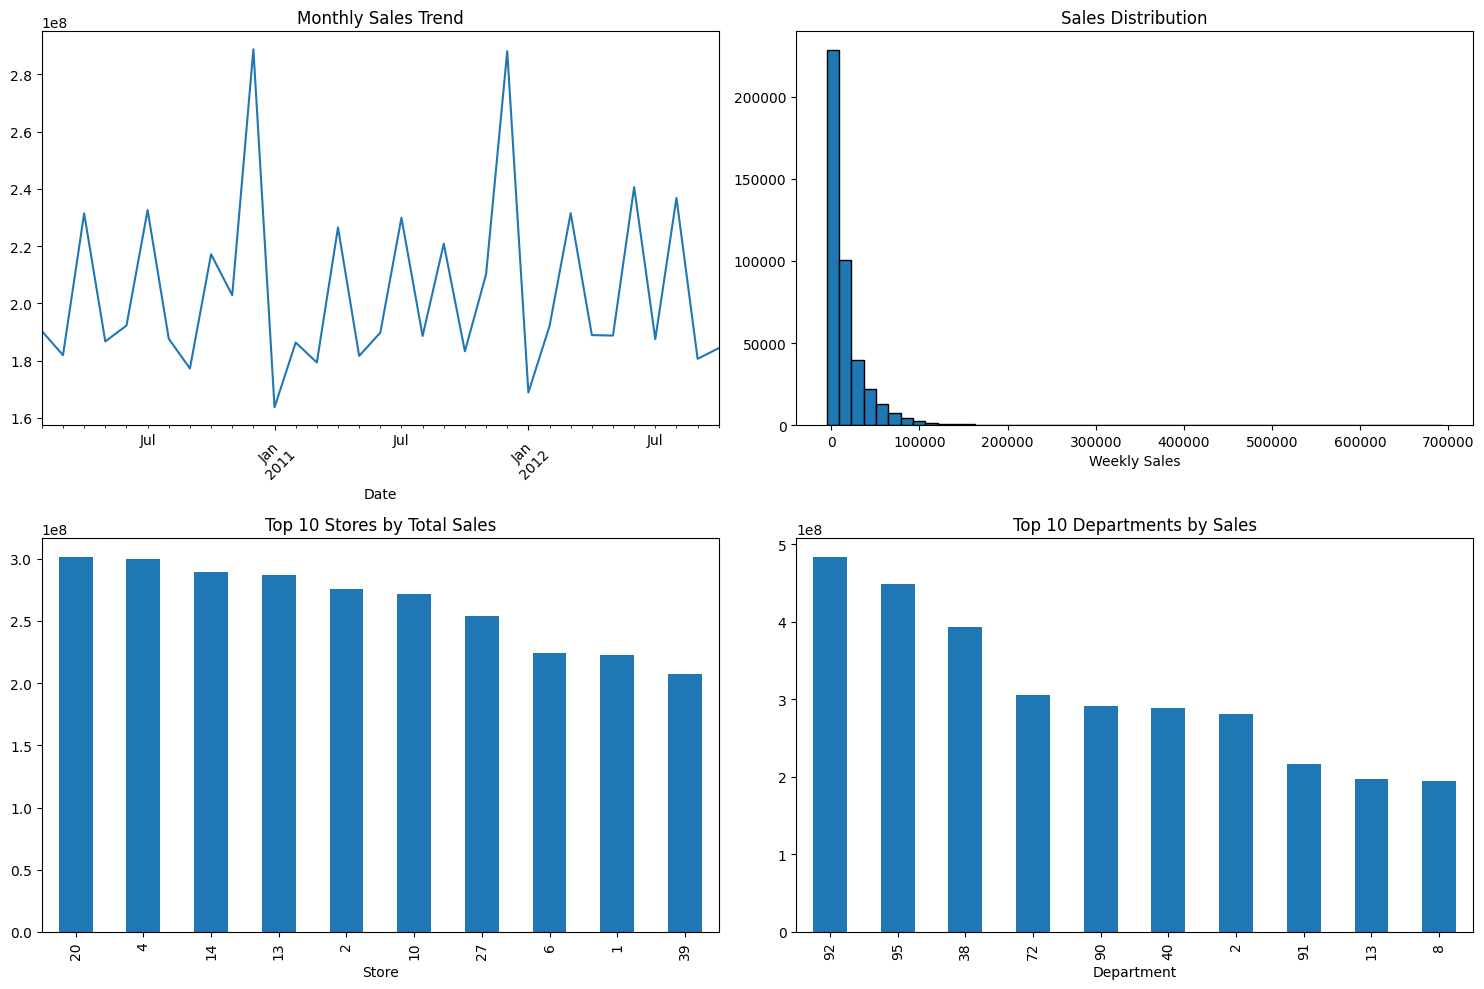


2. Preprocessing data...
Merging datasets...
Merged dataset shape: (421570, 17)
Creating time features...
Handling missing values...
Missing values after handling: 0
Creating lag features...
Creating rolling features...
Preparing features...
Final dataset shape: (382955, 41)
Number of features: 32

3. Creating datasets...


2025/07/07 19:05:09 INFO mlflow.tracking.fluent: Experiment with name 'PatchTST_Training' does not exist. Creating a new experiment.


Train samples: 135696
Validation samples: 38142
Test samples: 18979

4. Initializing PatchTST model...
Model parameters: 437644

5. Training model...
Epoch 0: Train Loss: 609216400.6300, Val Loss: 417904559.6120


In [ ]:
def create_inference_pipeline(model_path, scaler_path=None):
    """
    Create inference pipeline for production use
    """
    # Load model from MLflow Model Registry
    client = MlflowClient()

    # Get latest version of the model
    model_version = client.get_latest_versions("patchtst_walmart", stages=["Production"])[0]
    model_uri = f"models:/patchtst_walmart/{model_version.version}"

    # Load model
    model = mlflow.pytorch.load_model(model_uri)

    def predict(input_data):
        """
        Make predictions on new data
        """
        model.eval()
        with torch.no_grad():
            if isinstance(input_data, np.ndarray):
                input_data = torch.FloatTensor(input_data)

            predictions = model(input_data)
            return predictions.numpy()

    return predict

# Execute main pipeline
if __name__ == "__main__":
    model, results, config = main()